In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns
import time

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.table import Table, join

from dustmaps.sfd import SFDQuery

import healpy as hp
import pandas as pd
from sklearn.neighbors import KDTree

In [2]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

## Read in data

In [3]:
#tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
tab_gaia = Table.read('../data/gaia_slim.fits', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia))

Total number of Gaia quasars: 6649162


In [4]:
G_max_spz = 20.5
fn_spz = f'../data/redshifts_spz_kNN_G{G_max_spz}_noself.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [5]:
tab_gaia = astropy.table.join(tab_gaia, tab_spz, keys='source_id', join_type='left')

In [6]:
idx_withspz = np.isfinite(tab_gaia['redshift_spz'])
np.sum(idx_withspz)

1104830

In [7]:
idx_withsdss = np.isfinite(tab_gaia['redshift_sdss'])
np.sum(idx_withsdss)

260114

In [8]:
fn_sdss = '../data/sdss_slim.fits'
tab_sdss = Table.read(fn_sdss, format='fits')

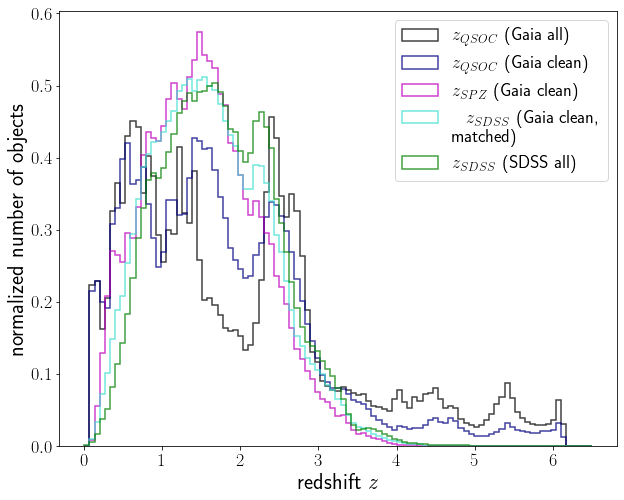

In [9]:
alpha = 0.75
lw = 1.5
density = True
histtype='step'
z_bins = np.linspace(0,6.5,100)

plt.figure(figsize=(10,8))
_ = plt.hist(tab_gaia['redshift_qsoc'], bins=z_bins, alpha=alpha, color='k', lw=lw,
             density=density, histtype=histtype, label=r'$z_{QSOC}$ (Gaia all)')
_ = plt.hist(tab_gaia['redshift_qsoc'][idx_withspz], bins=z_bins, alpha=alpha, color='navy', lw=lw,
             density=density, histtype=histtype, label=r'$z_{QSOC}$ (Gaia clean)')
_ = plt.hist(tab_gaia['redshift_spz'], bins=z_bins, alpha=alpha, color='m', lw=lw, 
             density=density, histtype=histtype, label=r'$z_{SPZ}$ (Gaia clean)')
_ = plt.hist(tab_gaia['redshift_sdss'], bins=z_bins, alpha=alpha, color='turquoise', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$ (Gaia clean,\\matched)')
_ = plt.hist(tab_sdss['Z'], bins=z_bins, alpha=alpha, color='g', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$ (SDSS all)')
plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number of objects')
plt.legend()

Text(0, 0.5, '$z_{QSOC}$, Gaia QSOC redshift')

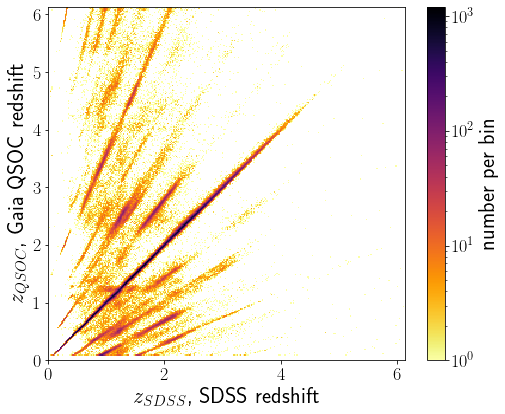

In [10]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_gaia['redshift_sdss'], tab_gaia['redshift_qsoc'], bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{QSOC}$, Gaia QSOC redshift')

Text(0, 0.5, '$z_{QSOC}$, Gaia QSOC redshift')

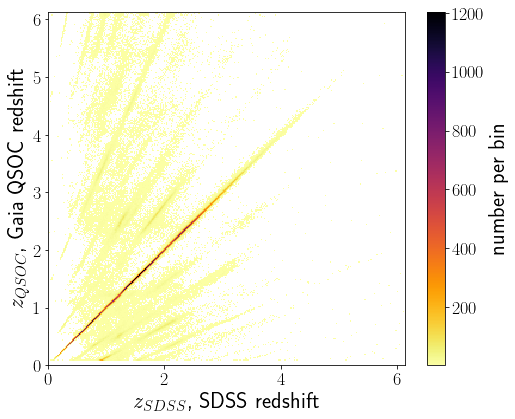

In [11]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_gaia['redshift_sdss'], tab_gaia['redshift_qsoc'], bins=z_bins, cmin=1, cmap='inferno_r',
             )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{QSOC}$, Gaia QSOC redshift')

In [45]:
def get_fraction_recovered(Y_true, Y_hat, z_err_close, over_1pz=False):
    dz = np.abs(Y_true - Y_hat)  
    if over_1pz:
        dz /= (1+Y_true)
    return np.sum(dz < z_err_close) / len(Y_true)

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

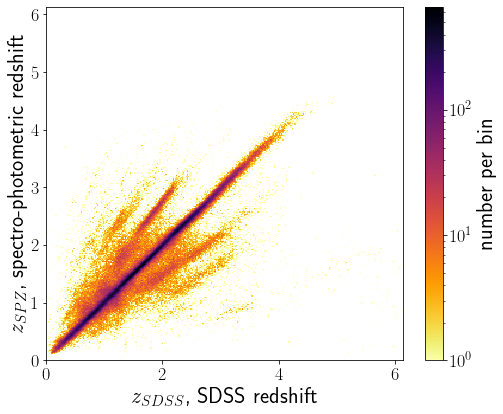

In [13]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_gaia['redshift_sdss'], tab_gaia['redshift_spz'], bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

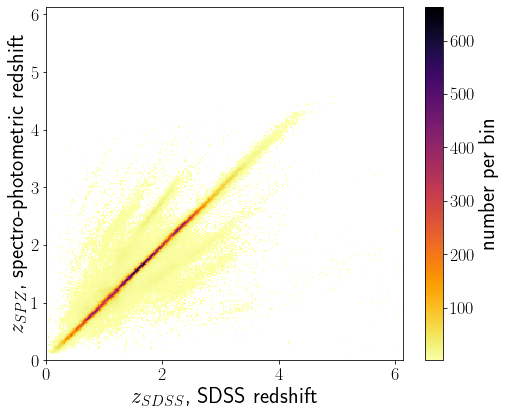

In [14]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_gaia['redshift_sdss'], tab_gaia['redshift_spz'], bins=z_bins, cmin=1, cmap='inferno_r',
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

In [15]:
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['redshift_sdss'][idx_withsdss]))
for z_err_close in z_errs_close:
    frac_recovered = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss], 
                                            tab_gaia['redshift_spz'][idx_withsdss], z_err_close)
    frac_recovered_baseline = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss], z_err_close)
    print(rf"Fraction recovered with dz<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  260114
Fraction recovered with $\delta z$<0.1: 0.775
(Baseline: 0.719)
Fraction recovered with $\delta z$<0.2: 0.838
(Baseline: 0.726)


In [46]:
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['redshift_sdss'][idx_withsdss]))
for z_err_close in z_errs_close:
    frac_recovered = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss], 
                                            tab_gaia['redshift_spz'][idx_withsdss], z_err_close, over_1pz=True)
    frac_recovered_baseline = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss], z_err_close, over_1pz=True)
    print(rf"Fraction recovered with dz/(1+z)<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  260114
Fraction recovered with $\delta z$<0.1: 0.846
(Baseline: 0.727)
Fraction recovered with $\delta z$<0.2: 0.914
(Baseline: 0.746)


# G<20 only

In [16]:
G_max = 20
idx_G = tab_gaia['phot_g_mean_mag'][idx_withsdss] < G_max
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['redshift_sdss'][idx_withsdss][idx_G]))
for z_err_close in z_errs_close:
    frac_recovered = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss][idx_G], 
                                            tab_gaia['redshift_spz'][idx_withsdss][idx_G], z_err_close)
    frac_recovered_baseline = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss][idx_G], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss][idx_G], z_err_close)
    print(rf"Fraction recovered with dz<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  168065
Fraction recovered with $\delta z$<0.1: 0.869
(Baseline: 0.818)
Fraction recovered with $\delta z$<0.2: 0.909
(Baseline: 0.823)


In [47]:
G_max = 20
idx_G = tab_gaia['phot_g_mean_mag'][idx_withsdss] < G_max
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['redshift_sdss'][idx_withsdss][idx_G]))
for z_err_close in z_errs_close:
    frac_recovered = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss][idx_G], 
                                            tab_gaia['redshift_spz'][idx_withsdss][idx_G], z_err_close, over_1pz=True)
    frac_recovered_baseline = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss][idx_G], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss][idx_G], z_err_close, over_1pz=True)
    print(rf"Fraction recovered with dz/(1+z)<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  168065
Fraction recovered with dz/(1+z)<0.1: 0.912
(Baseline: 0.823)
Fraction recovered with dz/(1+z)<0.2: 0.947
(Baseline: 0.832)


## Cumulative dist

In [17]:
delta_z = tab_gaia['redshift_sdss'][idx_withsdss] - tab_gaia['redshift_spz'][idx_withsdss]
delta_z_G = tab_gaia['redshift_sdss'][idx_withsdss][idx_G] - tab_gaia['redshift_spz'][idx_withsdss][idx_G]

Text(0, 0.5, 'number per bin')

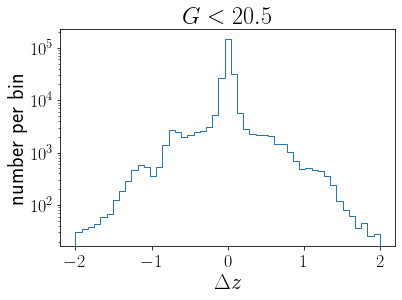

In [18]:
plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(delta_z, bins=np.linspace(-2,2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z$')
plt.ylabel('number per bin')

(0.0, 1.0)

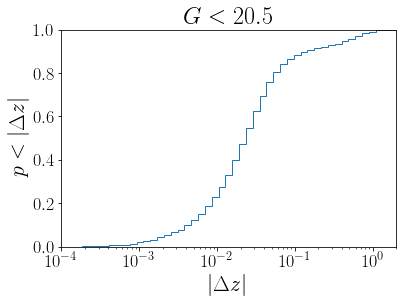

In [19]:
plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(abs(delta_z_G), bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|$')
plt.ylabel(r'$p < |\Delta z|$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)

Text(0, 0.5, 'number per bin')

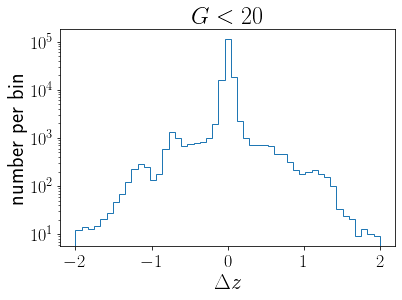

In [20]:
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(delta_z_G, bins=np.linspace(-2,2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z$')
plt.ylabel('number per bin')

(0.0, 1.0)

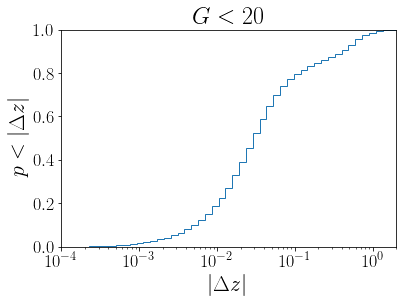

In [21]:
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(abs(delta_z), bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|$')
plt.ylabel(r'$p < |\Delta z|$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)

# precision

In [22]:
len(tab_gaia['redshift_qsoc']-tab_gaia['redshift_sdss'])

6649162

In [23]:
z_sdss = tab_gaia['redshift_sdss'][idx_withsdss]
z_spz = tab_gaia['redshift_spz'][idx_withsdss]
z_qsoc = tab_gaia['redshift_qsoc'][idx_withsdss]

#dz_spz = (z_spz-z_sdss)
#dz_qsoc = (z_qsoc-z_sdss)
dz_spz = (z_spz-z_sdss)/(1+z_sdss)
dz_qsoc = (z_qsoc-z_sdss)/(1+z_sdss)

In [24]:
dz_bins = np.linspace(np.min(dz_qsoc), np.max(dz_qsoc), 80)

0.7750678548636367
0.845656135386792 0.7268313124245523
0.7750678548636367 0.7185464834649423


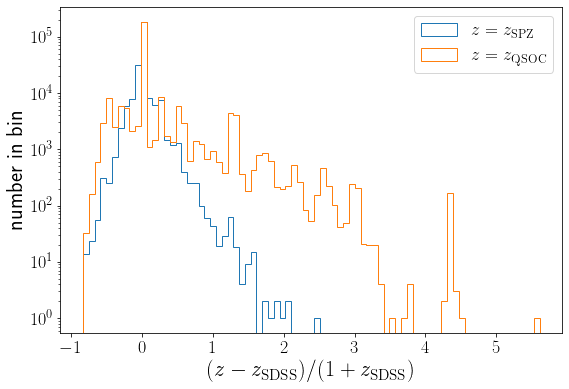

In [25]:
plt.figure(figsize=(9,6))
plt.hist(dz_spz, bins=dz_bins, histtype='step', label=r'$z=z_\mathrm{SPZ}$')
plt.hist(dz_qsoc, bins=dz_bins, histtype='step', label=r'$z=z_\mathrm{QSOC}$')
plt.xlabel(r'$(z - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')
plt.ylabel('number in bin')
plt.legend()
print(get_fraction_recovered(z_spz, z_sdss, 0.1))
print(np.sum(np.abs(dz_spz) < 0.1)/len(dz_spz), np.sum(np.abs(dz_qsoc) < 0.1)/len(dz_qsoc))
#print(np.sum(np.abs(dz_spz) < 0.2)/len(dz_spz), np.sum(np.abs(dz_qsoc) < 0.2)/len(dz_qsoc))
print(np.sum(np.abs(z_spz-z_sdss) < 0.1)/len(dz_spz), np.sum(np.abs(z_qsoc-z_sdss) < 0.1)/len(dz_qsoc))
plt.yscale('log')

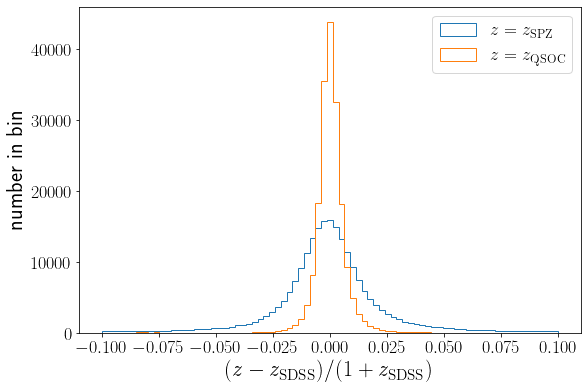

In [26]:
plt.figure(figsize=(9,6))
near_zero_bins = np.linspace(-0.1, 0.1, 80)
plt.hist(dz_spz, bins=near_zero_bins, histtype='step', label=r'$z=z_\mathrm{SPZ}$')
plt.hist(dz_qsoc, bins=near_zero_bins, histtype='step', label=r'$z=z_\mathrm{QSOC}$')
plt.xlabel(r'$(z - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')
plt.ylabel('number in bin')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


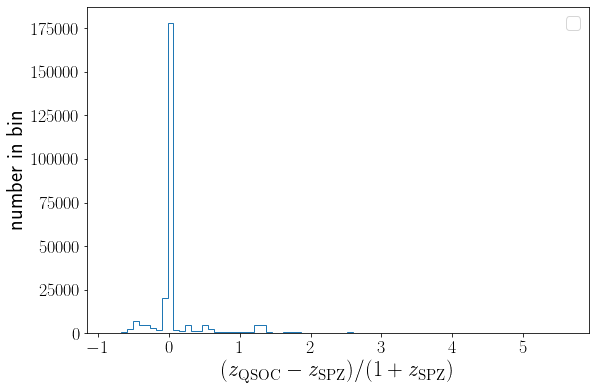

In [27]:
dz_qsoc_spz = (z_qsoc-z_spz)/(1+z_spz)

plt.figure(figsize=(9,6))
near_zero_bins = np.linspace(-0.1, 0.1, 80)
plt.hist(dz_qsoc_spz, bins=dz_bins, histtype='step')
plt.xlabel(r'$(z_\mathrm{QSOC} - z_\mathrm{SPZ})/(1 + z_\mathrm{SPZ})$')
plt.ylabel('number in bin')
plt.legend()
#plt.yscale('log')

In [108]:
dz_thresh = 0.1
i_qsoc_spz_agree = np.abs(dz_qsoc_spz) < dz_thresh
n_agree = np.sum(i_qsoc_spz_agree)
f_agree = n_agree / len(dz_qsoc_spz)
print(f"{f_agree:.3f} of QSOC and SPZ redshifts agree to dz<0.1")
print(len(i_qsoc_spz_agree), len(dz_qsoc_spz))

0.767 of QSOC and SPZ redshifts agree to dz<0.1
260114 260114


But if they agree, is QSOC right?

In [116]:
print(len(dz_qsoc[i_qsoc_spz_agree]))
i_qsocright_qsocspzagree = np.abs(dz_qsoc[i_qsoc_spz_agree]) < dz_thresh
print(f"Where QSOC and SPZ redshifts agree, QSOC is correct for {np.sum(i_qsocright_qsocspzagree)/len(dz_qsoc[i_qsoc_spz_agree]):.3f}")

i_qsocright_qsocspzdisagree = np.abs(dz_qsoc[~i_qsoc_spz_agree]) < dz_thresh
print(f"Where they don't, QSOC is correct for {np.sum(i_qsocright_qsocspzdisagree)/len(dz_qsoc[~i_qsoc_spz_agree]):.3f}")


i_spzright_qsocspzdisagree = np.abs(dz_spz[~i_qsoc_spz_agree]) < dz_thresh
print(f"Where they don't, SPZ is correct for {np.sum(i_spzright_qsocspzdisagree)/len(dz_spz[~i_qsoc_spz_agree]):.3f}")


print(len(dz_qsoc[i_qsoc_spz_agree]))

199467
Where QSOC and SPZ redshifts agree, QSOC is correct for 0.919
Where they don't, QSOC is correct for 0.096
Where they don't, SPZ is correct for 0.600
199467


So let's take QSOC where they agree for precision, SPZ elsewhere for accuracy:

In [118]:
z_spzqsoc = z_spz
z_spzqsoc[i_qsoc_spz_agree] = z_qsoc[i_qsoc_spz_agree]
dz_spzqsoc = (z_spzqsoc-z_sdss)/(1+z_sdss)

0.7952436239494991
0.845656135386792 0.7268313124245523
0.7952436239494991 0.7185464834649423


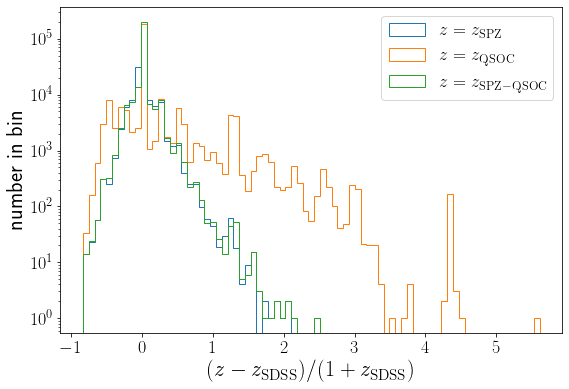

In [119]:
plt.figure(figsize=(9,6))
plt.hist(dz_spz, bins=dz_bins, histtype='step', label=r'$z=z_\mathrm{SPZ}$')
plt.hist(dz_qsoc, bins=dz_bins, histtype='step', label=r'$z=z_\mathrm{QSOC}$')
plt.hist(dz_spzqsoc, bins=dz_bins, histtype='step', label=r'$z=z_\mathrm{SPZ-QSOC}$')
plt.xlabel(r'$(z - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')
plt.ylabel('number in bin')
plt.legend()
print(get_fraction_recovered(z_spz, z_sdss, 0.1))
print(np.sum(np.abs(dz_spz) < 0.1)/len(dz_spz), np.sum(np.abs(dz_qsoc) < 0.1)/len(dz_qsoc))
#print(np.sum(np.abs(dz_spz) < 0.2)/len(dz_spz), np.sum(np.abs(dz_qsoc) < 0.2)/len(dz_qsoc))
print(np.sum(np.abs(z_spz-z_sdss) < 0.1)/len(dz_spz), np.sum(np.abs(z_qsoc-z_sdss) < 0.1)/len(dz_qsoc))
plt.yscale('log')

0.7952436239494991
0.845656135386792 0.7268313124245523
0.7952436239494991 0.7185464834649423


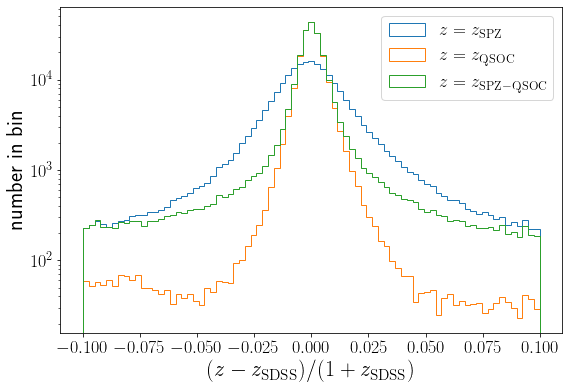

In [120]:
plt.figure(figsize=(9,6))
plt.hist(dz_spz, bins=near_zero_bins, histtype='step', label=r'$z=z_\mathrm{SPZ}$')
plt.hist(dz_qsoc, bins=near_zero_bins, histtype='step', label=r'$z=z_\mathrm{QSOC}$')
plt.hist(dz_spzqsoc, bins=near_zero_bins, histtype='step', label=r'$z=z_\mathrm{SPZ-QSOC}$')
plt.xlabel(r'$(z - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')
plt.ylabel('number in bin')
plt.legend()
print(get_fraction_recovered(z_spz, z_sdss, 0.1))
print(np.sum(np.abs(dz_spz) < 0.1)/len(dz_spz), np.sum(np.abs(dz_qsoc) < 0.1)/len(dz_qsoc))
#print(np.sum(np.abs(dz_spz) < 0.2)/len(dz_spz), np.sum(np.abs(dz_qsoc) < 0.2)/len(dz_qsoc))
print(np.sum(np.abs(z_spz-z_sdss) < 0.1)/len(dz_spz), np.sum(np.abs(z_qsoc-z_sdss) < 0.1)/len(dz_qsoc))
plt.yscale('log')

Bit better!

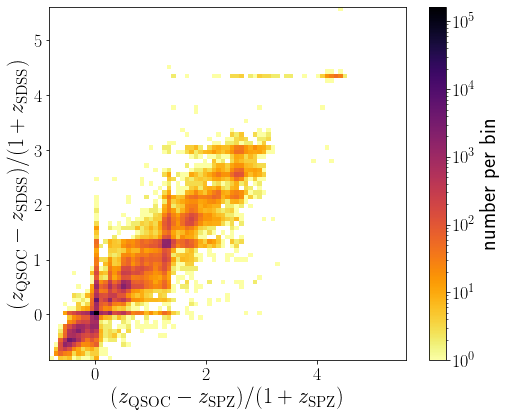

In [99]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
#h = ax.hist2d(tab_gaia['redshift_sdss'], tab_gaia['redshift_spz'], bins=z_bins, cmin=1, cmap='inferno_r' )
h = ax.hist2d(dz_qsoc_spz, dz_qsoc, 
          bins=dz_bins, cmin=1, cmap='inferno_r',
          norm=matplotlib.colors.LogNorm())

plt.xlabel(r'$(z_\mathrm{QSOC} - z_\mathrm{SPZ})/(1 + z_\mathrm{SPZ})$')
plt.ylabel(r'$(z_\mathrm{QSOC} - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')

fig.colorbar(h[3], ax=ax, label='number per bin')

#plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
#plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

Not obviously...

Not sure how useful this plot is but

Text(0, 0.5, '$(z_\\mathrm{QSOC} - z_\\mathrm{SDSS})/(1 + z_\\mathrm{SDSS})$')

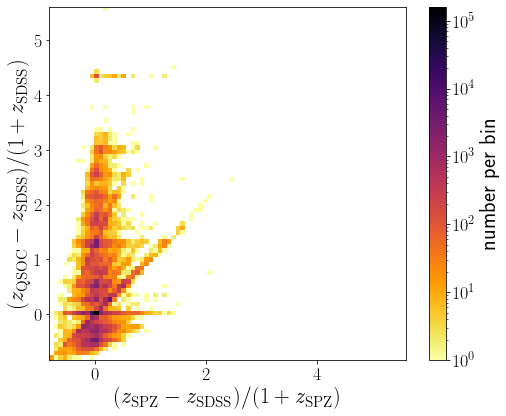

In [121]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
#h = ax.hist2d(tab_gaia['redshift_sdss'], tab_gaia['redshift_spz'], bins=z_bins, cmin=1, cmap='inferno_r' )
h = ax.hist2d(dz_spz, dz_qsoc, 
          bins=dz_bins, cmin=1, cmap='inferno_r',
          norm=matplotlib.colors.LogNorm())

fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$(z_\mathrm{SPZ} - z_\mathrm{SDSS})/(1 + z_\mathrm{SPZ})$')
plt.ylabel(r'$(z_\mathrm{QSOC} - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')

# G-cut dependence of outliers

In [91]:
dz_thresh = 0.1
G_arr = tab_gaia['phot_g_mean_mag'][idx_withsdss]
G_maxs = np.linspace(17, 20.5, 10)
n_insample = np.empty(len(G_maxs), dtype=int)
f_outliers = np.empty(len(G_maxs))
for i in range(len(G_maxs)):
    i_insample = G_arr < G_maxs[i]
    n_insample[i] = np.sum(i_insample)
    f_outliers[i] = np.sum(dz_spz[i_insample] > dz_thresh) / n_insample[i]
    print(G_maxs[i], n_insample[i], f_outliers[i])

17.0 998 0.027054108216432865
17.38888888888889 2309 0.01862278042442616
17.77777777777778 5245 0.012583412774070544
18.166666666666668 11933 0.01064275538422861
18.555555555555557 24924 0.011675493500240731
18.944444444444443 48178 0.01610693677612188
19.333333333333332 82861 0.024378175498726784
19.72222222222222 127557 0.03744208471506856
20.11111111111111 186575 0.05857697976684979
20.5 260114 0.08659280161775222


(17.0, 20.5)

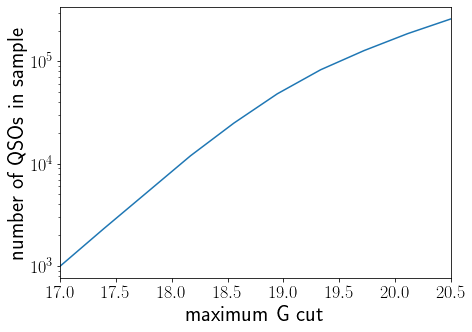

In [94]:
plt.figure(figsize=(7,5))
plt.plot(G_maxs, n_insample)
plt.xlabel("maximum G cut")
plt.ylabel(fr'number of QSOs in sample')
plt.yscale('log')
plt.xlim(np.min(G_maxs), np.max(G_maxs))

(17.0, 20.5)

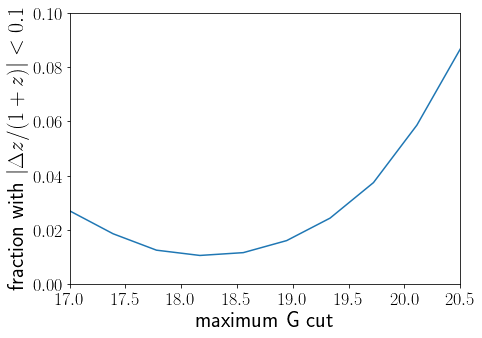

In [95]:
plt.figure(figsize=(7,5))
plt.plot(G_maxs, f_outliers)
plt.xlabel("maximum G cut")
plt.ylabel(fr'fraction with $|\Delta z/(1+z)|<{dz_thresh}$')
plt.ylim(0, 0.1)
plt.xlim(np.min(G_maxs), np.max(G_maxs))